In [150]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

from pprint import pprint

In [151]:
import numpy as np
import pandas as pd

In [152]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [153]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# for inspecting columns
from sqlalchemy import inspect

In [154]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [155]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [156]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [157]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [158]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [159]:
inspector = inspect(engine)
inspector.get_table_names()
inspector.get_columns("measurement")

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


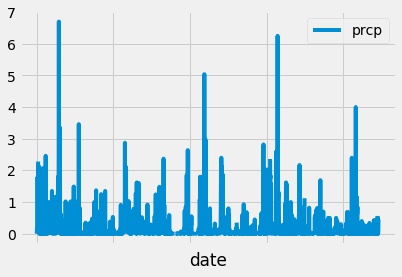

In [160]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precips = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
for precip in precips:
    #print(precip.date)
    last_date = precip.date

# Calculate the date 1 year ago from the last data point in the database

    # Convert last date to datetime object
cutoff_date = dt.date.fromisoformat(last_date) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precips = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= cutoff_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
DatePrcp = pd.DataFrame(precips)
    #set data as index
DatePrcp = DatePrcp.set_index("date")

# Sort the dataframe by date
DatePrcp = DatePrcp.sort_index()
display(DatePrcp)

# Use Pandas Plotting with Matplotlib to plot the data
DatePrcp.plot()

![precipitation](Images/precipitation.png)

In [161]:
# Use Pandas to calcualte the summary statistics for the precipitation data
DatePrcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [162]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(stations)

9


In [163]:
# What are the most active stations? (i.e. what stations have the most rows)?
row_count = func.count(Measurement.station).label('count')
stations = session.query(row_count, Measurement.station).group_by(Measurement.station).order_by(row_count.desc())
for station in stations:
    print(station)

    # most active station
best_station = stations[0][1]

(2772, 'USC00519281')
(2724, 'USC00519397')
(2709, 'USC00513117')
(2669, 'USC00519523')
(2612, 'USC00516128')
(2202, 'USC00514830')
(1979, 'USC00511918')
(1372, 'USC00517948')
(511, 'USC00518838')


In [164]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == best_station).all()
print(temps)

[(54.0, 85.0, 71.66378066378067)]


In [165]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).filter(Measurement.station == best_station).filter(Measurement.date >= cutoff_date).all()
temps_df = pd.DataFrame(temps)
temps_df.(bins=12)
#pprint(temps)

SyntaxError: invalid syntax (<ipython-input-165-5cfc7b6ff569>, line 5)

![precipitation](Images/station-histogram.png)

In [166]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [169]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2011-02-28', '2011-03-05')

<BarContainer object of 1 artists>

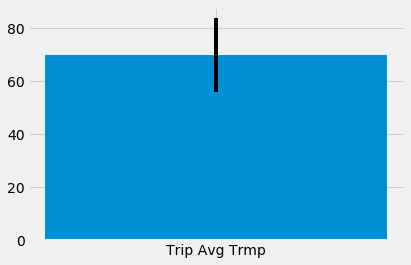

In [170]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar("Trip Avg Trmp", trip_temps[0][1], yerr=(trip_temps[0][2]-trip_temps[0][0]))


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
